In [18]:
# This notebook should be the centralized point for conformational analysis of Mpro trajectories.
# It allows for creating custom features based on certain atoms of certain residues.
# Then, we can look at histograms of all pairs of these features comparing to initial
# conformations.
# Next, we can re-structure those feature files to form a single trajectory of ALL features for
# each trajectory and use this as input for tICA.
# Through tICA, we can cluster the projection, create an MSM to assign populations, plot the
# projection (with cluster identities overlaid) and save the N closest frames to each
# cluster's center.

In [1]:
import itertools,glob,os,re
from tqdm import notebook
import mdtraj as md
import numpy as np

# Run this cell to compute and save distances (takes about five minutes as is)
# and generates about 700MB of feature data

for directory in notebook.tqdm(glob.glob('Trajectories/*')):
    ident = re.sub('.*P','P',directory) # get just the PROJ_RUN_CLONE identifier
    try: # load in trajectory, skipping if files don't exist
        traj = md.load(f'{directory}/traj.xtc',top=f'{directory}/xtc.gro')
    except Exception as e:
        continue
        
    # get several different groups of indices
    PHE140_indices = [a.index for a in traj.topology.atoms if a.residue.index
      in [141] and a.name in ['CG','CD1','CD2','CE1','CE2','CZ']]
    HIS163_indices = [a.index for a in traj.topology.atoms if a.residue.index
      in [164] and a.name in ['CG','ND1','CD2','CE1','NE2']]
    CYS145_indices = [a.index for a in traj.topology.atoms if a.residue.index 
      in [146] and a.name in ['SG']]
    HIS41_indices = [a.index for a in traj.topology.atoms if a.residue.index
      in [42] and a.name in ['CG','ND1','CD2','CE1','NE2']]
    GLU166_indices = [a.index for a in traj.topology.atoms if a.residue.index
      in [167] and a.name in ['CD']]
    TYR126_indices = [a.index for a in traj.topology.atoms if a.residue.index
      in [127] and a.name in ['CG','CZ','CE1','CE2','CD1','CD2']]
    all_indices = [PHE140_indices,HIS163_indices,CYS145_indices,HIS41_indices,
        GLU166_indices,TYR126_indices]
    
    # for each combination of these index pairs, compute atom index pairs, distances, labels,
    # and save distances/feature_labels to a directory
    for x,i in enumerate(all_indices):
        for y,j in enumerate(all_indices):
            if i != j and x<y:

                pairs = list(itertools.product(i,j))
                feature_labels = [[[str(traj.topology.atom(z[0]).residue.index) +
                    traj.topology.atom(z[0]).residue.name,traj.topology.atom(z[0]).name],
                  [str(traj.topology.atom(z[1]).residue.index) + 
                   traj.topology.atom(z[1]).residue.name,traj.topology.atom(z[1]).name]
                    ] for z in pairs]
                
                feature_directory = f'Features/{feature_labels[0][0][0]}_{feature_labels[0][1][0]}'
                # skip if we've already processed these features for this trajectory
                if os.path.exists(f'{feature_directory}/{ident}.npy'):
                    continue
                distances = md.compute_distances(traj,pairs)

                if not os.path.exists(f'{feature_directory}/feature_labels.npy'):
                    try:
                        os.makedirs(feature_directory)
                        np.save(f'{feature_directory}/feature_labels.npy',feature_labels)
                    except Exception as e:
                        np.save(f'{feature_directory}/feature_labels.npy',feature_labels)
                np.save(f'{feature_directory}/{ident}.npy',distances)
                


        


  0%|          | 0/870 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

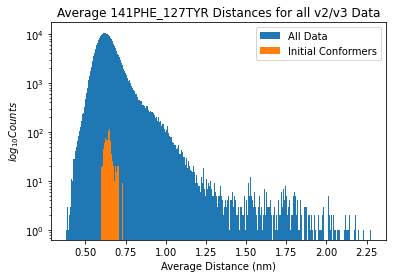

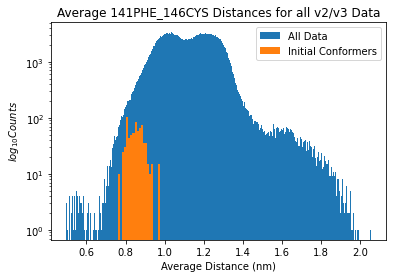

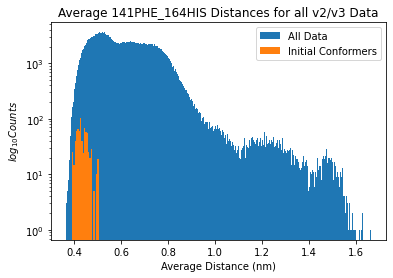

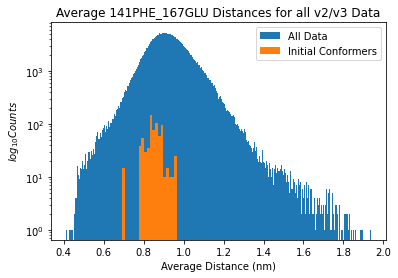

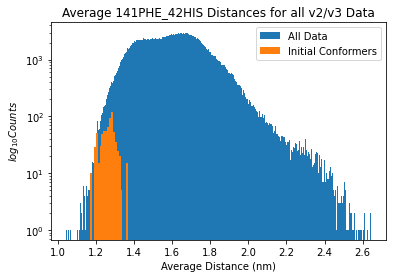

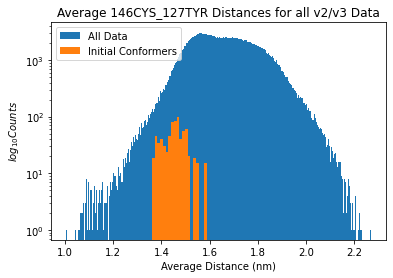

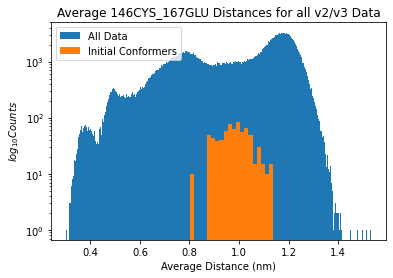

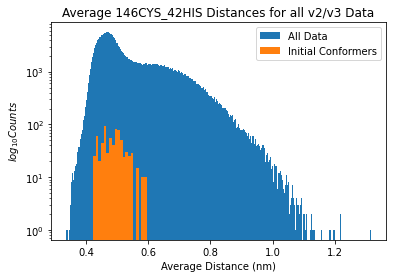

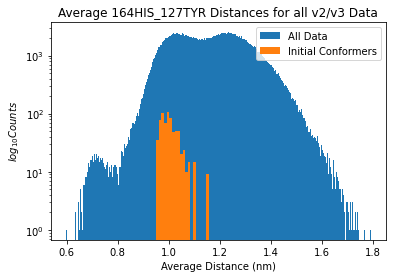

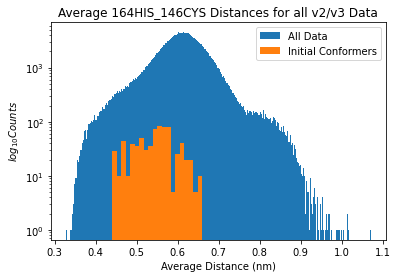

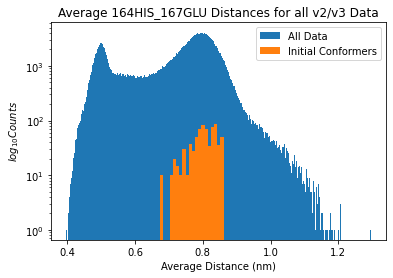

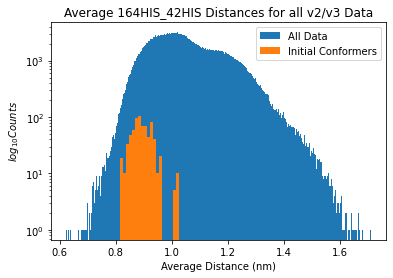

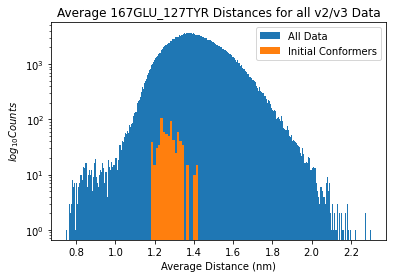

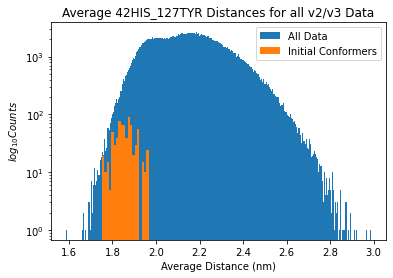

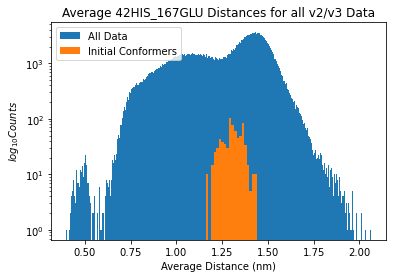

In [9]:
from tqdm import notebook
import glob, re
import numpy as np
from matplotlib import pyplot as plt

# This will make histograms for each of the previously extracted features
# with another histogram projected on top for features of initial conformers

for directory in notebook.tqdm(glob.glob('Features/*')):
    feature_name = re.sub('Features/','',directory)
    distances = []
    for file in glob.glob(f'{directory}/P*'):
        distances.append(np.load(file))
    # distances will be of shape (nTrajectories, nFrames, nDistances)
    # we can take the average of these distances for each frame to get an idea of
    # overall residue to residue changes
    average_distances, first_frame_averages = [],[]
    for i in distances: # for each traj
        for x,j in enumerate(i): # for each frame
            if x == 0:
                first_frame_averages.append(np.average(j))
            average_distances.append(np.average(j))
    # make a histogram for each feature with an overlayed histogram of initial distances
    plt.hist(average_distances,bins=1000, label='All Data')
    plt.hist(first_frame_averages,bins=20, label='Initial Conformers')
    plt.legend()
    plt.title(f'Average {feature_name} Distances for all v2/v3 Data')
    plt.xlabel('Average Distance (nm)')
    plt.ylabel('$log_{10} Counts$')
    plt.yscale('log')
    plt.show();plt.close()

In [13]:
from tqdm import notebook
import glob, os, re
import numpy as np

# This creates an overall feature file for each trajectory, basically re-structuring
# the files in Features to go by trajectory instead of feature.
# This generates another ~700MB of data since it just changes the shape of the other files.

if not os.path.exists(f'Features/tica_features'):
    os.makedirs(f'Features/tica_features')
    
feature_labels = [] # this contains descriptions of each feature
features = [] # this will contain all features for all frames for each trajectory
# loop through trajectories
for x,directory in notebook.tqdm(enumerate(glob.glob('Trajectories/*'))):
    ident = re.sub('.*P','P',directory)
    # go through each of the feature sets for that trajectory
    all_traj_features = []
    for feature_directory in glob.glob('Features/*'):
        # obviously don't process already processed tica features if they exist.
        feature_name = re.sub('Features/','', feature_directory)
        if 'features' in feature_name:
            continue
        if x == 0:
            feature_labels += list(np.load(f'{feature_directory}/feature_labels.npy'))

        if os.path.exists(f'{feature_directory}/{ident}.npy'):
            all_traj_features.append(np.load(f'{feature_directory}/{ident}.npy'))
        else:
            continue
    
    # put all the features together into a single array for each trajectory and save
    try:
        np.save(f'Features/tica_features/{ident}.npy',np.concatenate(all_traj_features, axis=1))
    except Exception as e:
        continue

np.save(f'Features/tica_features/feature_labels.npy', feature_labels)


0it [00:00, ?it/s]

In [1]:
# This cell contains function defintions from Tim's code for performing tICA
# Look to the cell below for actually performing tICA and outputting relevant structures.

def tica(feat, lag_time, save, save_dir, save_name):
    tica = pyemma.coordinates.tica(feat, dim=8, lag=lag_time, stride=1, kinetic_map=True, commute_map=False)
    tica_getoutput = tica.get_output()
    if save == True:
        tica.save(f'{save_dir}/tica_raw.h5', overwrite=True)
        np.save(f'{save_dir}/tica_output.npy', tica_getoutput)
    return tica_getoutput

def k_means(tica_getoutput, n_cluster, max_iter, save, save_dir, save_name):
    cluster = pyemma.coordinates.cluster_kmeans(tica_getoutput, k=n_cluster, max_iter=max_iter)
    cluster_getoutput = cluster.get_output()
    cluster_dtrajs = cluster.dtrajs
    cluster_centers = cluster.clustercenters
    if save == True:
        cluster.save(f'{save_dir}/{n_clusters}_clusters_raw.h5', overwrite=True)
        np.save(f'{save_dir}/{n_clusters}_clusters_output.npy', cluster_getoutput)
        np.save(f'{save_dir}/{n_clusters}_clusters_dtrajs.npy', cluster_dtrajs)
        np.save(f'{save_dir}/{n_clusters}_clusters_centers.npy', cluster_centers)
    return cluster, cluster_centers, cluster_dtrajs

def generate_msm(cluster, n_cluster, msm_lag, save, save_dir, save_name):
    msm = pyemma.msm.estimate_markov_model(cluster.dtrajs, msm_lag)
    if save == True:
        state_frac_used = msm.active_state_fraction
        count_frac_used = msm.active_count_fraction
        feat_act_set = msm.active_set
        eigvec = msm.eigenvectors_right()
        msm.save(f'{save_dir}/{n_cluster}_clusters_msm_raw.h5',  overwrite=True)
    return msm

def find_cluster_center_structures(cluster_centers, tica_output):
    pdb_ndxs, center_frames = [],[]
    for cluster_ndx in range(len(cluster_centers)):
        center_coords = cluster_centers[cluster_ndx]
        pdb_ndxs.append([])
        distances = pd.Series([np.linalg.norm(center_coords - x) for x in np.concatenate(
          tica_output)])
        min_distance_frames = distances.nsmallest(n_pdbs_to_save).index.values.tolist()
        center_frames.append(min_distance_frames[0])

        for frame in min_distance_frames:
            traj_ndx = 0
            for clone in tica_output:
                if frame > len(clone):
                    traj_ndx += 1
                    frame -= len(clone)
                else:
                    pdb_ndxs[cluster_ndx].append([traj_ndx,frame])
                    break
    return center_frames, pdb_ndxs


In [3]:
import glob, os, re
import pyemma
import mdtraj as md
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

# This cell loads in all the tICA-ready feature data, performs tICA, clusters in 
# tICA-space, plots tICA projections, creates an MSM to estimate populations, and
# outputs structures for each cluster center

tica_dir = 'pocket-tica' # directory to save results
feature_type='distances' # description of features
tica_lagtime = 100
n_clusters = 8
msm_lagtime = 100
n_pdbs_to_save = 5 # per cluster

# create some directories for output files
for sub_dir in ['plots', 'structures', 'objects']:
    if not os.path.exists(f'{tica_dir}/{sub_dir}'):
        os.makedirs(f'{tica_dir}/{sub_dir}')

features, traj_files = [],[]
# load in all the tica-ready featured data
for feature_file in glob.glob(f'Features/tica_features/*'):
    if 'feature_labels' in feature_file:
        continue
    ident = re.sub('.npy','',re.sub('.*tica_features/','',feature_file))
    traj_files.append(ident)
    features.append(np.load(feature_file))
    
# performing tICA
tica_output = tica(features, tica_lagtime, save=True,
  save_dir=f'{tica_dir}/objects', save_name=feature_type)

# clustering in tICA space
cluster, cluster_centers, cluster_dtrajs = k_means(tica_output, n_clusters,
  max_iter=100, save=True, save_dir=f'{tica_dir}/objects', save_name=feature_type)

# generating MSM from tICA projection
msm = generate_msm(cluster, n_clusters, msm_lagtime, save=True,
  save_dir=f'{tica_dir}/objects', save_name=feature_type)

print(f'Saving {n_pdbs_to_save} closest frames to each cluster...')
center_frames, pdb_ndxs = find_cluster_center_structures(cluster_centers, tica_output)
for i in range(n_clusters):
    pop = int(msm.stationary_distribution[i]*100)
    for j in range(n_pdbs_to_save):
        traj_file = f'Trajectories/{traj_files[pdb_ndxs[i][j][0]]}/traj.xtc'
        gro_file = f'Trajectories/{traj_files[pdb_ndxs[i][j][0]]}/xtc.gro'
        frame = md.load_frame(traj_file, pdb_ndxs[i][j][1], top=gro_file)
        frame.save_pdb(f'{tica_dir}/structures/{traj_files[pdb_ndxs[i][j][0]]}_f{pdb_ndxs[i][j][1]}_c{i}_p{pop}.pdb')

# making & saving plots of tICA projections
plt.figure(figsize=(10,10))
stride = 100
plt.suptitle(f'tICA Plots for Mpro Simulations With Cluster Centers', size=20)
coordinates = np.concatenate(np.asarray(tica_output))
cluster_colors = plt.get_cmap('rainbow')(np.linspace(0,1,n_clusters))
colors = [cluster_colors[c] for c in np.concatenate(cluster_dtrajs)[::stride]]
center_colors = [cluster_colors[c] for c in np.concatenate(cluster_dtrajs)[center_frames]]
legend_lines = [Line2D([0], [0], color=c, lw=4) for c in cluster_colors]

for x,dims in enumerate([[0,1],[0,2],[1,2],[2,3]]):
    X = coordinates[:,dims[0]]
    Y = coordinates[:,dims[1]]
    plt.subplot(2,2,x+1)
    plt.hexbin(X, Y, bins='log')
    plt.scatter(X[center_frames], Y[center_frames],
      color=center_colors, marker='*', s=24)
    for i in tica_output:
        plt.scatter(i[:,dims[0]][0], i[:,dims[1]][0], marker='*', color='k', s=12)
    if x == 1:
      plt.legend(legend_lines, [f'Cluster {n}, Pop: {msm.stationary_distribution[n]*100:.4f}'
        for n in range(n_clusters)], bbox_to_anchor=(1.05, 0.82, 0.3, 0.2), loc='upper left')
    plt.xlabel(f'tIC{dims[0]+1}')
    plt.ylabel(f'tIC{dims[1]+1}')
#plt.show()
plt.savefig(f'{tica_dir}/plots/tica.png')
plt.close()

# plot strided clusters on top of tICA projection
plt.figure(figsize=(10,10))
plt.suptitle(f'tICA Plots for Mpro Simulations with Clusters Shown', size=20)


for x,dims in enumerate([[0,1],[0,2],[1,2],[2,3]]):
    X = coordinates[:,dims[0]]
    Y = coordinates[:,dims[1]]
    plt.subplot(2,2,x+1)
    plt.hexbin(X, Y, bins='log')
    plt.scatter(X[::stride], Y[::stride], s=2, color=colors)
    if x == 1:
      plt.legend(legend_lines, [f'Cluster {n}, Pop: {msm.stationary_distribution[n]*100:.4f}'
        for n in range(n_clusters)], bbox_to_anchor=(1.05, 0.82, 0.3, 0.2), loc='upper left')
    plt.xlabel(f'tIC{dims[0]+1}')
    plt.ylabel(f'tIC{dims[1]+1}')
#plt.show()
plt.savefig(f'{tica_dir}/plots/tica_clusters.png')
plt.close()

# plot the MSM transition matrix
fig = plt.figure()
labels = [str(x) for x in range(n_clusters)]
ax = fig.add_subplot(111)
mat = ax.matshow(msm.P, interpolation='nearest')
fig.colorbar(mat)
ax.set_xticklabels(['']+labels)
ax.set_yticklabels(['']+labels)
plt.title('MSM Transition Matrix')
#plt.show()
plt.savefig(f'{tica_dir}/plots/transition_matrix.png')
plt.close()

# plot the MSM MFPT matrix
mfpt_mat = np.zeros((n_clusters, n_clusters))
for i in range(n_clusters):
    for j in range(n_clusters):
        mfpt_mat[i][j] = msm.mfpt(i,j)
fig = plt.figure()
labels = [str(x) for x in range(n_clusters)]
ax = fig.add_subplot(111)
mat = ax.matshow(mfpt_mat, interpolation='nearest')
fig.colorbar(mat)
ax.set_xticklabels(['']+labels)
ax.set_yticklabels(['']+labels)
plt.title('MSM log(MFPT) Matrix')
#plt.show()
plt.savefig(f'{tica_dir}/plots/MFPT_matrix.png')
plt.close()
np.save(f'{tica_dir}/objects/MFPT.npy',mfpt_mat)

calculate covariances:   0%|                                                       | 0/693 [00:00<?, ?it/s]

getting output of TICA:   0%|                                                      | 0/723 [00:00<?, ?it/s]

/home/matt/packages/miniconda3/envs/pyem/lib/python3.9/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


initialize kmeans++ centers:   0%|                                                   | 0/8 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                           | 0/100 [00:00<?, ?it/s]

getting output of KmeansClustering:   0%|                                          | 0/723 [00:00<?, ?it/s]

getting output of KmeansClustering:   0%|                                          | 0/723 [00:00<?, ?it/s]

/home/matt/packages/miniconda3/envs/pyem/lib/python3.9/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Saving 5 closest frames to each cluster...


/tmp/ipykernel_13088/3692580516.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  coordinates = np.concatenate(np.asarray(tica_output))
/tmp/ipykernel_13088/3692580516.py:110: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+labels)
/tmp/ipykernel_13088/3692580516.py:111: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+labels)
/tmp/ipykernel_13088/3692580516.py:127: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+labels)
/tmp/ipykernel_13088/3692580516.py:128: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+labels)


In [28]:
import pyemma
import pandas as pd
from matplotlib import pyplot as plt

labels = np.load(f'pocket-tica/feature_labels.npy')
tica = pyemma.load('pocket-tica/objects/tica_raw.h5')
n_top_features = 8

# Find the most "important" features per tICA component by the magnitude of the 
# eigenvector components. We can also normalize this magnitude using the standard
# deviation of that feature.

# get the first four eigenvectors
vecs = np.transpose(tica.eigenvectors)
# get the std of each distance feature
cat_features = np.concatenate(features)
feature_variance = [np.std(cat_features[:,x]) for x in range(len(vecs[0]))]

for tic in range(4): # for each of the first 4 components
    # plot the largest magnitude features for each component
    abs_vec = pd.Series(abs(vecs[tic]))
    plt.subplot(1,2,1)
    top_feature_indices = abs_vec.nlargest(n_top_features).index.values.tolist()
    plt.bar(range(n_top_features), vecs[tic][top_feature_indices])
    plt.xticks(range(n_top_features),
      [f"{'_'.join(labels[x][0])} - {'_'.join(labels[x][1])}" for x in top_feature_indices],
      rotation=90)
    plt.ylabel('Feature Magnitude')
    plt.title(f'Top {n_top_features} Features for tIC{tic+1}')
    
    # normalize these features by their variance and plot the highest magnitudes
    plt.subplot(1,2,2)
    norm_vec = np.asarray([vecs[tic][x] / feature_variance[x] for x in range(len(vecs[tic]))])
    norm_abs_vec = pd.Series(abs(norm_vec))
    top_feature_indices = norm_abs_vec.nlargest(n_top_features).index.values.tolist()
    plt.bar(range(n_top_features), norm_vec[top_feature_indices])#vecs[tic][top_feature_indices])
    plt.xticks(range(n_top_features),
      [f"{'_'.join(labels[x][0])} - {'_'.join(labels[x][1])}" for x in top_feature_indices],
      rotation=90)
    plt.ylabel('Feature Magnitude')
    plt.title(f'Top Normalized Features for tIC{tic+1}')
    plt.tight_layout()
    #plt.show()
    plt.savefig(f'{tica_dir}/plots/tIC{tic+1}_features.png')
    plt.close()

In [56]:
import itertools,glob,os,re
from tqdm import notebook
import mdtraj as md
import numpy as np

# Run this cell to compute and save CA distances (takes about 35 minutes as is)
# and generates about 2.2GB of feature data at CA_stride = 8

CA_stride = 8

if not os.path.exists(f'Features/CA{CA_stride}_tica_features'): 
    os.makedirs(f'Features/CA{CA_stride}_tica_features')

for directory in notebook.tqdm(glob.glob('Trajectories/*')):
    ident = re.sub('.*P','P',directory) # get just the PROJ_RUN_CLONE identifier
    try: # load in trajectory, skipping if files don't exist
        traj = md.load(f'{directory}/traj.xtc',top=f'{directory}/xtc.gro')
    except Exception as e:
        continue
        
    # get all of the alpha carbon indices
    CA_indices = [ a.index for a in traj.topology.atoms if a.name == 'CA']
    # striding by 8 brings CA features down to 703 instead of 46056
    pairs = list(itertools.combinations(CA_indices[::CA_stride], 2))
    distances = md.compute_distances(traj, pairs)
    np.save(f'Features/CA{CA_stride}_tica_features/{ident}.npy', distances)

  0%|          | 0/870 [00:00<?, ?it/s]

calculate covariances:   0%|                                                      | 0/693 [00:00<?, ?it/s]

getting output of TICA:   0%|                                                     | 0/723 [00:00<?, ?it/s]

11-02-22 15:31:18 pyemma._base.serialization.h5file INFO     overwriting model "default" in file tica_CA_stride_4/objects/tica_raw.h5


/home/matt/packages/miniconda3/envs/pyem/lib/python3.9/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


initialize kmeans++ centers:   0%|                                                  | 0/5 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                          | 0/100 [00:00<?, ?it/s]

getting output of KmeansClustering:   0%|                                         | 0/723 [00:00<?, ?it/s]

getting output of KmeansClustering:   0%|                                         | 0/723 [00:00<?, ?it/s]

/home/matt/packages/miniconda3/envs/pyem/lib/python3.9/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Saving 5 closest frames to each cluster...


/tmp/ipykernel_8864/1081791688.py:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  coordinates = np.concatenate(np.asarray(tica_output))


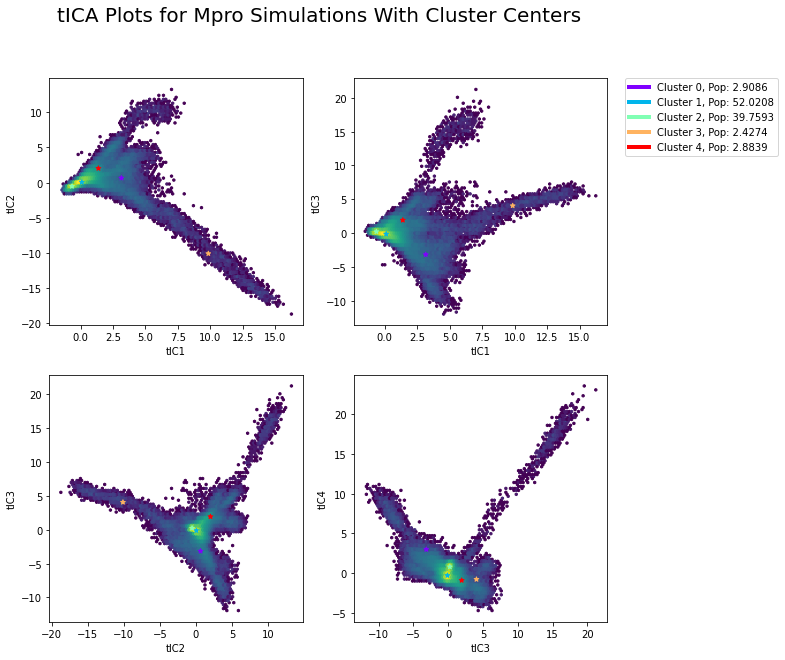

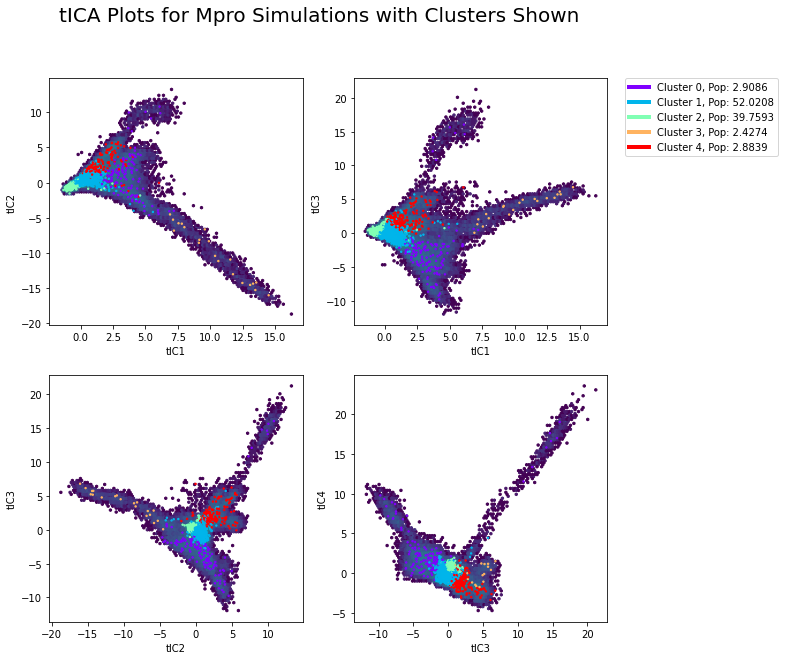

/tmp/ipykernel_8864/1081791688.py:108: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+labels)
/tmp/ipykernel_8864/1081791688.py:109: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+labels)


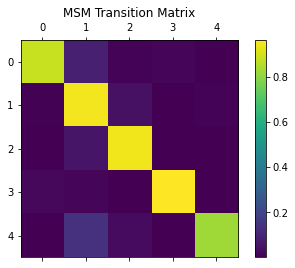

In [62]:
import glob, os, re
import pyemma
import mdtraj as md
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D

# Now let's run our tICA / MSM again with CA distance features to get a better sense
# of global conformational changes.
# All we have to change here is the feature directory and output file descriptors, but we 
# can also play around with different numbers of clusters.

tica_dir = f'tica_CA_stride_{CA_stride}' # directory to save results
feature_type=f'CA{CA_stride}_distances' # description of features
tica_lagtime = 100
n_clusters = 5
plot_clusters = True
msm_lagtime = 100
n_pdbs_to_save = 5 # per cluster

# create some directories for output files
for sub_dir in ['plots', 'structures', 'objects']:
    if not os.path.exists(f'{tica_dir}/{sub_dir}'):
        os.makedirs(f'{tica_dir}/{sub_dir}')

features, traj_files = [],[]
# load in all the tica-ready featured data
for feature_file in glob.glob(f'Features/CA{CA_stride}_tica_features/*'):
    ident = re.sub('.npy','',re.sub(f'.*CA{CA_stride}_tica_features/','',feature_file))
    traj_files.append(ident)
    features.append(np.load(feature_file))
    
# performing tICA
tica_output = tica(features, tica_lagtime, save=True,
  save_dir=f'{tica_dir}/objects', save_name=feature_type)

# clustering in tICA space
cluster, cluster_centers, cluster_dtrajs = k_means(tica_output, n_clusters,
  max_iter=100, save=True, save_dir=f'{tica_dir}/objects', save_name=feature_type)

# generating MSM from tICA projection
msm = generate_msm(cluster, n_clusters, msm_lagtime, save=True,
  save_dir=f'{tica_dir}/objects', save_name=feature_type)

print(f'Saving {n_pdbs_to_save} closest frames to each cluster...')
center_frames, pdb_ndxs = find_cluster_center_structures(cluster_centers, tica_output)
for i in range(n_clusters):
    pop = int(msm.stationary_distribution[i]*100)
    for j in range(n_pdbs_to_save):
        traj_file = f'Trajectories/{traj_files[pdb_ndxs[i][j][0]]}/traj.xtc'
        gro_file = f'Trajectories/{traj_files[pdb_ndxs[i][j][0]]}/xtc.gro'
        frame = md.load_frame(traj_file, pdb_ndxs[i][j][1], top=gro_file)
        frame.save_pdb(f'{tica_dir}/structures/{traj_files[pdb_ndxs[i][j][0]]}_f{pdb_ndxs[i][j][1]}_c{i}_p{pop}.pdb')

# making & saving plots of tICA projections
plt.figure(figsize=(10,10))
plt.suptitle(f'tICA Plots for Mpro Simulations With Cluster Centers', size=20)
coordinates = np.concatenate(np.asarray(tica_output))
cluster_colors = plt.get_cmap('rainbow')(np.linspace(0,1,n_clusters))
colors = [cluster_colors[c] for c in np.concatenate(cluster_dtrajs)[::stride]]
center_colors = [cluster_colors[c] for c in np.concatenate(cluster_dtrajs)[center_frames]]
legend_lines = [Line2D([0], [0], color=c, lw=4) for c in cluster_colors]

for x,dims in enumerate([[0,1],[0,2],[1,2],[2,3]]):
    X = coordinates[:,dims[0]]
    Y = coordinates[:,dims[1]]
    plt.subplot(2,2,x+1)
    plt.hexbin(X, Y, bins='log')
    plt.scatter(X[center_frames], Y[center_frames],
      color=center_colors, marker='*', s=24)
    if x == 1:
      plt.legend(legend_lines, [f'Cluster {n}, Pop: {msm.stationary_distribution[n]*100:.4f}'
        for n in range(n_clusters)], bbox_to_anchor=(1.05, 0.82, 0.3, 0.2), loc='upper left')
    plt.xlabel(f'tIC{dims[0]+1}')
    plt.ylabel(f'tIC{dims[1]+1}')
plt.show()
#plt.savefig(f'{tica_dir}/plots/tica.png')
plt.close()

# plot strided clusters on top of tICA projection
plt.figure(figsize=(10,10))
plt.suptitle(f'tICA Plots for Mpro Simulations with Clusters Shown', size=20)
stride = 100

for x,dims in enumerate([[0,1],[0,2],[1,2],[2,3]]):
    X = coordinates[:,dims[0]]
    Y = coordinates[:,dims[1]]
    plt.subplot(2,2,x+1)
    plt.hexbin(X, Y, bins='log')
    plt.scatter(X[::stride], Y[::stride], s=2, color=colors)
    if x == 1:
      plt.legend(legend_lines, [f'Cluster {n}, Pop: {msm.stationary_distribution[n]*100:.4f}'
        for n in range(n_clusters)], bbox_to_anchor=(1.05, 0.82, 0.3, 0.2), loc='upper left')
    plt.xlabel(f'tIC{dims[0]+1}')
    plt.ylabel(f'tIC{dims[1]+1}')
plt.show()
#plt.savefig(f'{tica_dir}/plots/tica_clusters.png')
plt.close()

# plot the MSM transition matrix
fig = plt.figure()
labels = [str(x) for x in range(n_clusters)]
ax = fig.add_subplot(111)
mat = ax.matshow(msm.P, interpolation='nearest')
fig.colorbar(mat)

ax.set_xticklabels(['']+labels)
ax.set_yticklabels(['']+labels)
plt.title('MSM Transition Matrix')

plt.show()
#plt.savefig(f'{tica_dir}/plots/transition_matrix.png')
plt.close()

5
